In [1]:
# # if used pip install package
# !pip install xgboost
# !pip install lightgbm
# !pip install wget

In [2]:
import os
import sys
import gc
import wget
import time
import tarfile
import zipfile
import random
from tqdm import tqdm_notebook, tqdm

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import xgboost as xgb
import lightgbm as lgb

from joblib import Parallel, delayed

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
DDIR = "data"
UDDIR = "user_data"
UFEDIR = "user_data/feat_data_v02"
UMDIR = "user_data/model_data"
RESDIR = "prediction_result"

In [4]:
UID = "user_id"

# Load data (Only once)

In [5]:
# train_fname = wget.download("https://tesla-ap-shanghai-1256322946.cos.ap-shanghai.myqcloud.com/cephfs/tesla_common/deeplearning/dataset/algo_contest/train_preliminary.zip", out=DDIR)
# test_fname = wget.download("https://tesla-ap-shanghai-1256322946.cos.ap-shanghai.myqcloud.com/cephfs/tesla_common/deeplearning/dataset/algo_contest/test.zip", out=DDIR)

In [6]:
# def myunzip(filename):
#     zFile = zipfile.ZipFile(filename, "r")
#     for fileM in zFile.namelist(): 
#         zFile.extract(fileM, DDIR)
#         print(fileM)
#     zFile.close()

In [7]:
# myunzip(train_fname)
# myunzip(test_fname)

# Utils

In [8]:
def bch_rencol(values, prefix="", suffix=""):
    return list(map(lambda x: f"{prefix}"+"_".join(list(map(lambda y: str(y), x)))+f"{suffix}" 
                    if hasattr(x, "__iter__") and not isinstance(x, str) 
                    else f"{prefix}"+str(x)+f"{suffix}", values))

In [9]:
def mynunique(values):
    return values.nunique(dropna=False)

In [10]:
def getidxmax(x):
    return x.idxmax()[1]

In [11]:
OP_SET = ["max", "mean", "std", getidxmax, "nunique"]

# Data Exploration (todo)

In [105]:
# read train data
train_click_log = pd.read_csv(f"{DDIR}/train_preliminary/click_log.csv")
train_ad = pd.read_csv(f"{DDIR}/train_preliminary/ad.csv")
# tag
train_user = pd.read_csv(f"{DDIR}/train_preliminary/user.csv")

In [13]:
# read test data
test_click_log = pd.read_csv(f"{DDIR}/test/click_log.csv")
test_ad = pd.read_csv(f"{DDIR}/test/ad.csv")

In [14]:
train_click_log.shape

(30082771, 4)

In [15]:
train_ad.shape

(2481135, 6)

In [16]:
train_user.shape

(900000, 3)

In [17]:
test_click_log.shape

(33585512, 4)

In [18]:
test_ad.shape

(2618159, 6)

In [19]:
train_ad["product_id"] = train_ad["product_id"].replace("\\N", -1).astype(int)
train_ad["industry"] = train_ad["industry"].replace("\\N", -1).astype(int)

In [20]:
test_ad["product_id"] = test_ad["product_id"].replace("\\N", -1).astype(int)
test_ad["industry"] = test_ad["industry"].replace("\\N", -1).astype(int)

In [21]:
# creative id in train (creative id is unique in train_ad)
len(train_ad)

2481135

In [22]:
# creative id in test (creative id is unique in test_ad)
len(test_ad)

2618159

In [23]:
# check whether the same creative_id in train and test have same ad info
insect1d = np.intersect1d(train_click_log.creative_id.unique(), test_click_log.creative_id.unique())
print("Same creative id: ", insect1d.shape)
print("Diff number: ", np.sum(train_ad[train_ad.creative_id.isin(insect1d)].values != test_ad[test_ad.creative_id.isin(insect1d)].values))
# checked: they all have same ad info (result is 0)

Same creative id:  (1686522,)
Diff number:  0


In [24]:
# check whether click and ad have diff creative_id
print("Diff list: ", np.setdiff1d(train_click_log.creative_id.unique(), train_ad.creative_id))
print("Diff list: ", np.setdiff1d(train_ad.creative_id, train_click_log.creative_id.unique()))

Diff list:  []
Diff list:  []


In [25]:
# check whether click and ad have diff creative_id
print("Diff list: ", np.setdiff1d(test_click_log.creative_id.unique(), test_ad.creative_id))
print("Diff list: ", np.setdiff1d(test_ad.creative_id, test_click_log.creative_id.unique()))

Diff list:  []
Diff list:  []


In [26]:
# data_grouped = data.groupby(data.index)
# results = Parallel(n_jobs=8)(delayed(key_func)(group) for name, group in data_grouped)
# data = pd.concat(results)

# Feature engineering

In [ ]:
tol_train = pd.merge(train_click_log, train_ad, how="left", on="creative_id")
tol_test = pd.merge(test_click_log, test_ad, how="left", on="creative_id")

In [ ]:
del train_click_log, train_ad
del test_click_log, test_ad

In [ ]:
gc.collect()

## Creative id map

In [27]:
train_ucid = pd.merge(train_click_log[[UID, "creative_id"]], train_user, how="left", on=UID)

In [28]:
cid_map = train_ucid.groupby(["creative_id"])[["age", "gender"]].agg(["mean"])
cid_map.columns = bch_rencol(cid_map.columns, prefix="creative_id_")

In [29]:
train_click_log = pd.merge(train_click_log, cid_map, how="left", on="creative_id")

In [30]:
test_click_log = pd.merge(test_click_log, cid_map, how="left", on="creative_id")

In [31]:
del cid_map

In [32]:
tmp = train_click_log.groupby([UID])["creative_id_age_mean", "creative_id_gender_mean"].agg(["sum", "max", "mean", "min", "std"])
tmp.columns = bch_rencol(tmp.columns)

/opt/conda/envs/tensorflow_py3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  if __name__ == '__main__':


In [33]:
tmp.to_pickle(f"{UFEDIR}/train_o1_cid_map.pkl")
tmp = None

In [34]:
tmp = test_click_log.groupby([UID])["creative_id_age_mean", "creative_id_gender_mean"].agg(["sum", "max", "mean", "min", "std"])
tmp.columns = bch_rencol(tmp.columns)

/opt/conda/envs/tensorflow_py3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  if __name__ == '__main__':


In [35]:
tmp.to_pickle(f"{UFEDIR}/test_o1_cid_map.pkl")
tmp = None

## User Click log (Order 1)

In [ ]:
# for train
tmp = tol_train.groupby([UID], sort=False).agg(
    {
        UID: ["count"], 
        "click_times": ["sum", "max", "mean", "std"],
        "time": ["nunique", "mean", "max", "min"],
        "creative_id": ["nunique"],
        "ad_id": ["nunique"],
        "product_id": ["nunique"],
        "product_category": ["nunique"],
        "advertiser_id": ["nunique"],
        "industry": ["nunique"],
    }
)

In [ ]:
tmp.columns = bch_rencol(tmp.columns)

In [ ]:
tmp.to_pickle(f"{UFEDIR}/train_o1.pkl")
tmp = None

In [ ]:
# for test
tmp = tol_test.groupby([UID], sort=False).agg(
    {
        UID: ["count"], 
        "click_times": ["sum", "max", "mean", "std"],
        "time": ["nunique", "mean", "max", "min"],
        "creative_id": ["nunique"],
        "ad_id": ["nunique"],
        "product_id": ["nunique"],
        "product_category": ["nunique"],
        "advertiser_id": ["nunique"],
        "industry": ["nunique"],
    }
)

In [ ]:
tmp.columns = bch_rencol(tmp.columns)

In [ ]:
tmp.to_pickle(f"{UFEDIR}/test_o1.pkl")
tmp = None

In [ ]:
gc.collect()

## User Click log (Order 2)

In [ ]:
# train
for col in ["creative_id", "ad_id", "product_id", "product_category", "advertiser_id", "industry"]:
    tmp = tol_train.groupby([UID, col], sort=False)[[col]].agg(["count"]).groupby([UID]).agg(OP_SET)
    tmp.columns = bch_rencol(tmp.columns)
    tmp.to_pickle(f"{UFEDIR}/train_o2_{col}.pkl")
    tmp = None

In [ ]:
# test
for col in ["creative_id", "ad_id", "product_id", "product_category", "advertiser_id", "industry"]:
    tmp = tol_test.groupby([UID, col], sort=False)[[col]].agg(["count"]).groupby([UID]).agg(OP_SET)
    tmp.columns = bch_rencol(tmp.columns)
    tmp.to_pickle(f"{UFEDIR}/test_o2_{col}.pkl")
    tmp = None

In [ ]:
gc.collect()

## One-Hot

In [ ]:
# train
tmp = tol_train.groupby([UID, "product_category"], sort=False)[["product_category"]].agg(["count"]).unstack().fillna(0)
tmp.columns = bch_rencol(tmp.columns)

In [ ]:
tmp.to_pickle(f"{UFEDIR}/train_onehot.pkl")
tmp = None

In [ ]:
# test
tmp = tol_test.groupby([UID, "product_category"], sort=False)[["product_category"]].agg(["count"]).unstack().fillna(0)
tmp.columns = bch_rencol(tmp.columns)

In [ ]:
tmp.to_pickle(f"{UFEDIR}/test_onehot.pkl")
tmp = None

In [ ]:
gc.collect()

## Time Windows (Time Bins)

In [ ]:
bins = 9
tol_bins = pd.cut(pd.concat([tol_train["time"], tol_test["time"]]), bins, labels=range(bins))

In [ ]:
tol_train[f"bins{bins}"] = tol_bins[:len(tol_train)]
tol_test[f"bins{bins}"] = tol_bins[len(tol_train):]

In [ ]:
tol_train.

### Order 1

In [ ]:
# train
tmp = tol_train.groupby([UID, f"bins{bins}"], sort=False).agg(
    {
        UID: ["count"], 
        "click_times": ["sum", "max", "mean", "std"],
        "time": ["nunique", "mean", "max", "min"],
        "creative_id": ["nunique"],
        "ad_id": ["nunique"],
        "product_id": ["nunique"],
        "product_category": ["nunique"],
        "advertiser_id": ["nunique"],
        "industry": ["nunique"],
    }
).unstack()

In [ ]:
tmp.columns = bch_rencol(tmp.columns, prefix=f"bins{bins}_")

In [ ]:
tmp.to_pickle(f"{UFEDIR}/train_bins{bins}_o1.pkl")
tmp = None

In [ ]:
# test
tmp = tol_test.groupby([UID, f"bins{bins}"], sort=False).agg(
    {
        UID: ["count"], 
        "click_times": ["sum", "max", "mean", "std"],
        "time": ["nunique", "mean", "max", "min"],
        "creative_id": ["nunique"],
        "ad_id": ["nunique"],
        "product_id": ["nunique"],
        "product_category": ["nunique"],
        "advertiser_id": ["nunique"],
        "industry": ["nunique"],
    }
).unstack()

In [ ]:
tmp.columns = bch_rencol(tmp.columns, prefix=f"bins{bins}_")

In [ ]:
tmp.to_pickle(f"{UFEDIR}/test_bins{bins}_o1.pkl")
tmp = None

In [ ]:
gc.collect()

### Order 2

In [ ]:
# train
for col in ["creative_id", "ad_id", "product_id", "product_category", "advertiser_id", "industry"]:
    for i in range(bins):
        tmp = tol_train[tol_train[f"bins{bins}"] == i].groupby([UID, col], sort=False)[[col]].agg(["count"]).groupby([UID]).agg(OP_SET)
        tmp.columns = bch_rencol(tmp.columns, prefix=f"bins{bins}_{i}_")
        tmp.to_pickle(f"{UFEDIR}/train_bins{bins}_{i}_o2_{col}.pkl")
        tmp = None

In [ ]:
# test
for col in ["creative_id", "ad_id", "product_id", "product_category", "advertiser_id", "industry"]:
    for i in range(bins):
        tmp = tol_test[tol_test[f"bins{bins}"] == i].groupby([UID, col], sort=False)[[col]].agg(["count"]).groupby([UID]).agg(OP_SET)
        tmp.columns = bch_rencol(tmp.columns, prefix=f"bins{bins}_{i}_")
        tmp.to_pickle(f"{UFEDIR}/test_bins{bins}_{i}_o2_{col}.pkl")
        tmp = None

In [ ]:
gc.collect()

## Conact

In [36]:
train_feat = pd.DataFrame()
test_feat = pd.DataFrame()
train_feat[UID] = train_user[UID]
test_feat[UID] = np.sort(test_click_log[UID].unique())

In [37]:
feat_fname = os.listdir(UFEDIR)

In [38]:
for fname in feat_fname:
    if fname.startswith("train_"):
        train_feat = pd.merge(train_feat, pd.read_pickle(f"{UFEDIR}/{fname}"), how="left", on=UID)
    elif fname.startswith("test_"):
        test_feat = pd.merge(test_feat, pd.read_pickle(f"{UFEDIR}/{fname}"), how="left", on=UID)

In [39]:
# to make sure feat and user(target) have same order
# if true --> sum == 0
np.sum(train_feat[UID] != train_user[UID])

0

In [40]:
train_feat.shape

(900000, 56)

In [41]:
test_feat.shape

(1000000, 56)

In [42]:
# del tol_test

In [43]:
train_feat.to_pickle(f"{UDDIR}/feat_ing/train_feat_tol_v2.pkl")
test_feat.to_pickle(f"{UDDIR}/feat_ing/test_feat_tol_v2.pkl")

In [ ]:
train_feat = pd.read_pickle(f"{UDDIR}/train_feat_tol.pkl")
test_feat = pd.read_pickle(f"{UDDIR}/test_feat_tol.pkl")
train_user = pd.read_csv(f"{DDIR}/train_preliminary/user.csv")

In [ ]:
train_feat.drop([col for col in train_feat.columns if col.find("bins") != -1], axis=1, inplace=True)

In [ ]:
test_feat.drop([col for col in test_feat.columns if col.find("bins") != -1], axis=1, inplace=True)

In [ ]:
# list(train_feat.columns)

In [ ]:
# train_feat["industry_count_getidxmax"] = train_feat["industry_count_getidxmax"].replace("\\N", -1).astype(float)
# train_feat["product_id_count_getidxmax"] = train_feat["product_id_count_getidxmax"].replace("\\N", -1).astype(float)
# test_feat["industry_count_getidxmax"] = test_feat["industry_count_getidxmax"].replace("\\N", -1).astype(float)
# test_feat["product_id_count_getidxmax"] = test_feat["product_id_count_getidxmax"].replace("\\N", -1).astype(float)

# Training&Prediction

In [44]:
# split data
train_feat_tr, train_feat_val, train_tag_tr, train_tag_val = train_test_split(train_feat, train_user, test_size=0.2)

In [45]:
del train_feat, train_user

In [46]:
train_feat_tr.drop(UID, axis=1, inplace=True)

In [47]:
train_feat_val.drop(UID, axis=1, inplace=True)

In [48]:
gc.collect()

21

## For Age

In [58]:
lgbds_train_tr_age = lgb.Dataset(train_feat_tr, train_tag_tr["age"]-1)
lgbds_train_val_age = lgb.Dataset(train_feat_val, train_tag_val["age"]-1)

In [59]:
params_age = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "num_class": 10,
    "metric": "multi_error",
    "learning_rate": 0.1,
}

In [60]:
model_lgb_multi_age = lgb.train(params_age, lgbds_train_tr_age, num_boost_round=1000, valid_sets=[lgbds_train_val_age], verbose_eval=50, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds
[50]	valid_0's multi_error: 0.443761
[100]	valid_0's multi_error: 0.435289
[150]	valid_0's multi_error: 0.431572
[200]	valid_0's multi_error: 0.430756
[250]	valid_0's multi_error: 0.42955
[300]	valid_0's multi_error: 0.4292
[350]	valid_0's multi_error: 0.429211
[400]	valid_0's multi_error: 0.42895
[450]	valid_0's multi_error: 0.4285
[500]	valid_0's multi_error: 0.427983
[550]	valid_0's multi_error: 0.427739
[600]	valid_0's multi_error: 0.428939
[650]	valid_0's multi_error: 0.4318
Early stopping, best iteration is:
[586]	valid_0's multi_error: 0.427367


In [61]:
ndt = time.strftime("%Y%m%d%H%M%S", time.localtime(int(time.time())))
model_lgb_multi_age.save_model(f"{UMDIR}/lgb_multi_age_{ndt}.model")

In [62]:
train_val_age_prob = model_lgb_multi_age.predict(train_feat_val, num_iteration=model_lgb_multi_age.best_iteration)

In [63]:
train_val_age_pred = [list(x).index(max(x))+1 for x in train_val_age_prob]

In [64]:
age_acy = accuracy_score(train_val_age_pred, train_tag_val["age"])

In [ ]:
# print("Done")

## For Gender

In [49]:
lgbds_train_tr_gender = lgb.Dataset(train_feat_tr, train_tag_tr["gender"]-1)
lgbds_train_val_gender = lgb.Dataset(train_feat_val, train_tag_val["gender"]-1)

In [50]:
params_gender = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "num_class": 2,
    "metric": "multi_error",
    "learning_rate": 0.1,
}

In [51]:
model_lgb_multi_gender = lgb.train(params_gender, lgbds_train_tr_gender, num_boost_round=1000, valid_sets=[lgbds_train_val_gender], verbose_eval=50, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds
[50]	valid_0's multi_error: 0.01865
[100]	valid_0's multi_error: 0.0187278
Early stopping, best iteration is:
[48]	valid_0's multi_error: 0.0186056


In [52]:
ndt = time.strftime("%Y%m%d%H%M%S", time.localtime(int(time.time())))
model_lgb_multi_gender.save_model(f"{UMDIR}/lgb_multi_gender_{ndt}.model")

In [53]:
train_val_gender_prob = model_lgb_multi_gender.predict(train_feat_val, num_iteration=model_lgb_multi_gender.best_iteration)

In [54]:
train_val_gender_pred = [list(x).index(max(x))+1 for x in train_val_gender_prob]

In [55]:
gender_acy = accuracy_score(train_val_gender_pred, train_tag_val["gender"])

In [56]:
gender_acy

0.9813944444444445

In [66]:
# total accuracy
age_acy + gender_acy

1.5540277777777778

# Generate Prediction Result

In [ ]:
model_lgb_multi_age = lgb.Booster(model_file=f"{UMDIR}/lgb_multi_age_20200511045531.model")

In [ ]:
model_lgb_multi_gender = lgb.Booster(model_file=f"{UMDIR}/lgb_multi_gender_20200511034408.model")

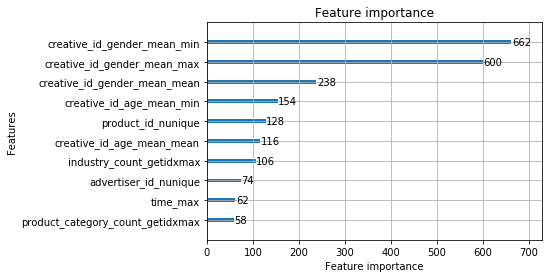

In [67]:
lgb.plot_importance(model_lgb_multi_gender, max_num_features=10)

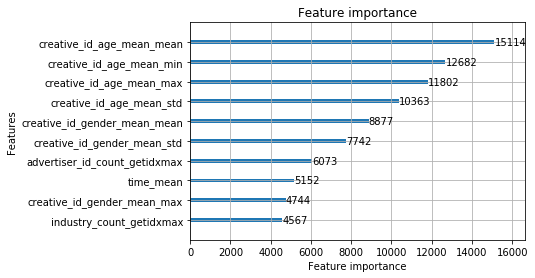

In [68]:
lgb.plot_importance(model_lgb_multi_age, max_num_features=10)

In [69]:
res = test_feat[[UID]]

In [70]:
test_feat.drop(UID, axis=1, inplace=True)

In [71]:
res["predicted_age"] = [list(x).index(max(x))+1 for x in model_lgb_multi_age.predict(test_feat, num_iteration=model_lgb_multi_age.best_iteration)]

/opt/conda/envs/tensorflow_py3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [72]:
res["predicted_gender"] = [list(x).index(max(x))+1 for x in model_lgb_multi_gender.predict(test_feat, num_iteration=model_lgb_multi_gender.best_iteration)]

/opt/conda/envs/tensorflow_py3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [74]:
res_suffix = time.strftime("%Y%m%d%H%M%S", time.localtime(int(time.time())))
res.to_csv(f"{RESDIR}/res-{res_suffix}.csv", index=False)

In [100]:
res["predicted_gender"].value_counts()

2    998391
1      1609
Name: predicted_gender, dtype: int64

In [101]:
o_res = pd.read_csv("./prediction_result/res-20200509035457.csv")

In [102]:
o1_res = pd.read_csv("./prediction_result/res-20200510025147.csv")

In [99]:
o1_res["predicted_gender"].value_counts()

2    992505
1      7495
Name: predicted_gender, dtype: int64

In [103]:
o_res["predicted_gender"].value_counts()

1    792762
2    207238
Name: predicted_gender, dtype: int64

In [106]:
train_user["gender"].value_counts()

1    602610
2    297390
Name: gender, dtype: int64

# Cent result to COS

In [82]:
from ti import session
ti_session = session.Session()

In [83]:
inputs = ti_session.upload_data(path=f"{RESDIR}/res-20200511084649.csv", bucket="etveritas-1252104022", key_prefix=RESDIR)